### Develop an ML Linear Regression model to learn High Entropy Alloy Hardness Property

In this tutorial we will learn to create an ML model for hardness property prediction for high entropy alloys. We will go through the following steps:

1. Load training dataset and separate X and y columns
2. Visualize the alloy property and feature data
3. Use scikit-learn library to build alloy hardness prediction model (linear regression)
4. Model assessment, cross-validation
5. Polynomial regression
6. Regularization using CV


The dataset for this tutorial is taken from the following publication:

Wen, Cheng, et al. "Machine learning assisted design of high entropy alloys with desired property." Acta Materialia 170 (2019): 109-117 (https://doi.org/10.1016/j.actamat.2019.03.010).


### Import python libraries

In [ ]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import copy

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV

### 1. Load train data table

In [ ]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 13.4MB/s]


In [ ]:
data = pd.read_csv('alloy-confp-train-data_v2.csv')
data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


#### Notes about the data table

Above we see that data table has 3 types of columns:
1. ID: Serial number of the alloys.
2. HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
3. C.*: concentration of different elements in the alloys.

#### Separate X and y data

In [ ]:
Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


In [ ]:
y = data['HV']
y

0      139
1      295
2      545
3      701
4      207
      ... 
115    249
116    450
117    451
118    617
119    171
Name: HV, Length: 120, dtype: int64

### 2. Visualize data

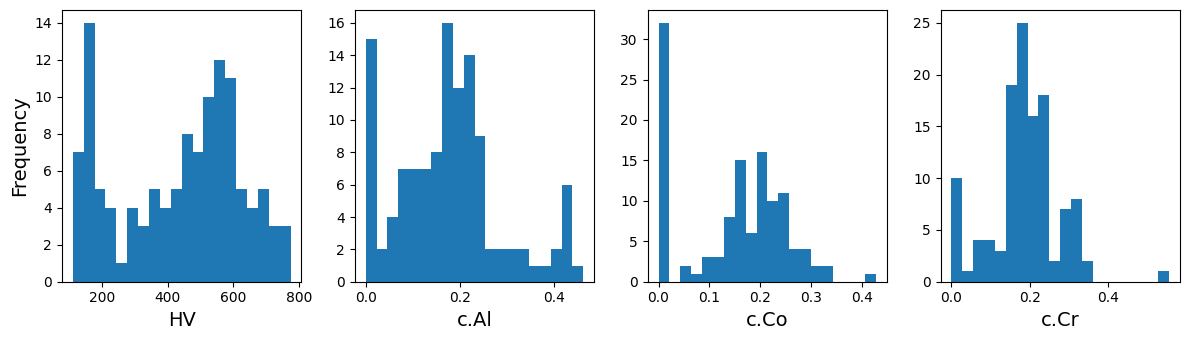

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5))

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

### Question
1. Why is it important to visualize data?

### 3. Train an ML model

In [ ]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

#### Our own LR code using the equation discuseed in class

In [ ]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X))
X_tras_y = np.dot(X.T,y)
w_cap_vec = np.dot(X_tras_X_inv,X_tras_y)
y_pred_manual = np.dot(X,w_cap_vec)

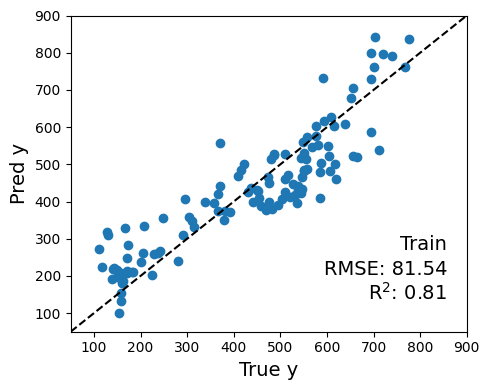

In [ ]:
polt_parity(y,y_pred_manual, label="Train")

#### Using sklearn in-built python library

In [ ]:
lr = LinearRegression(fit_intercept=False)
model = lr.fit(X,y)
lr_model = copy.deepcopy(model)

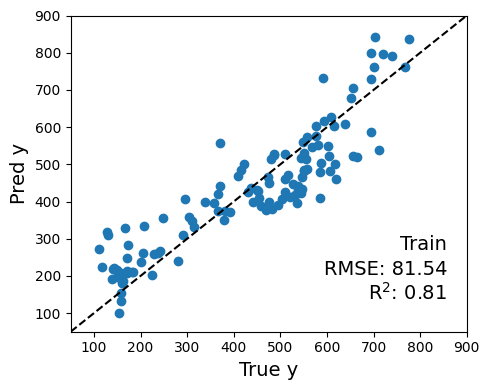

In [ ]:
y_pred = model.predict(X)
polt_parity(y,y_pred, label="Train")

#### Comparing sklearn library vs our equation results 

In [ ]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


#### Error with baseline average model

In [ ]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


### Question
2. Why is it important to compare model performance with a baseline model?
3. Is there any issue with the way we have computed the accuracy/ performance of the linear regression model?

### 4. Model assessment, cross-validation

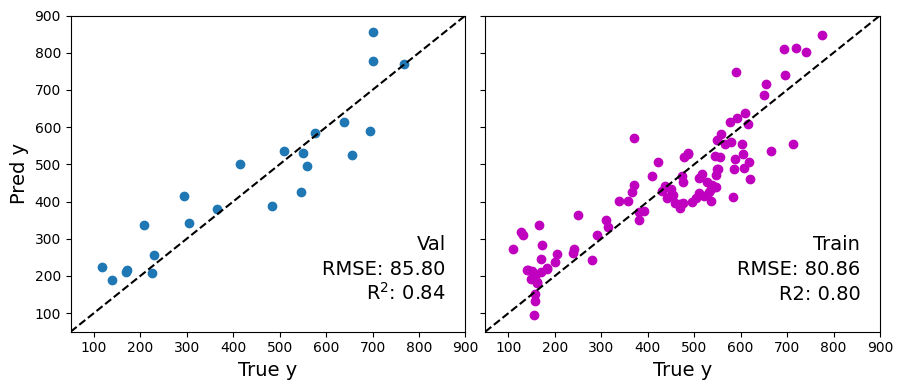

Root mean squared error: 85.80
Coefficient of determination: 0.84


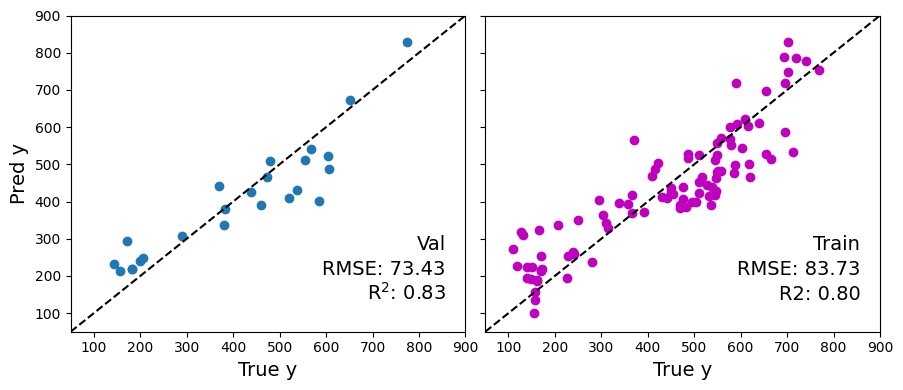

Root mean squared error: 73.43
Coefficient of determination: 0.83


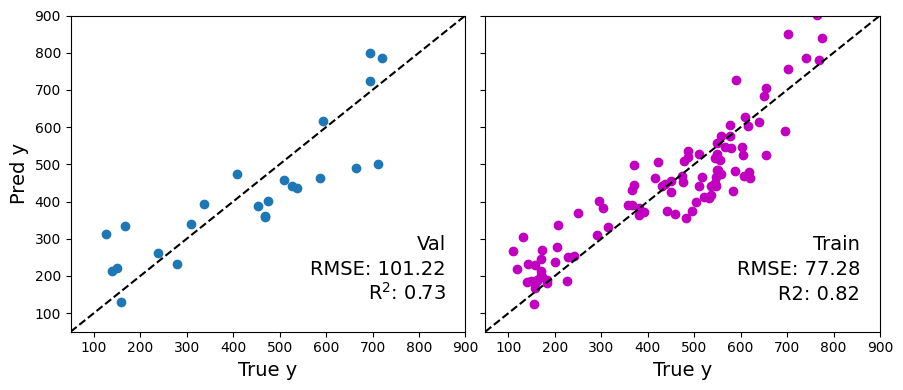

Root mean squared error: 101.22
Coefficient of determination: 0.73


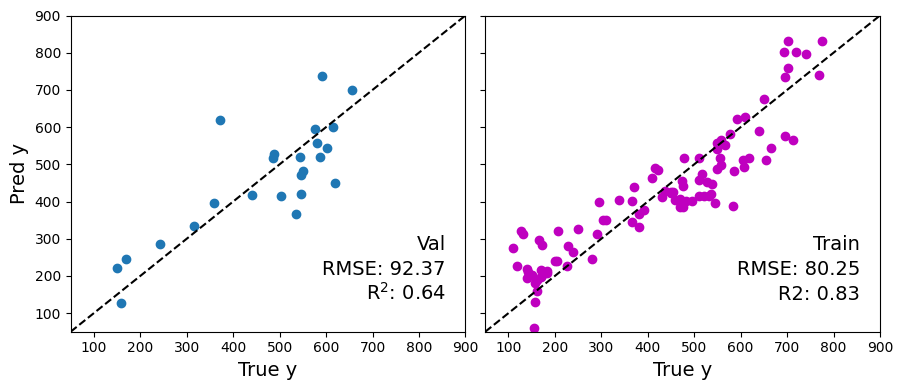

Root mean squared error: 92.37
Coefficient of determination: 0.64


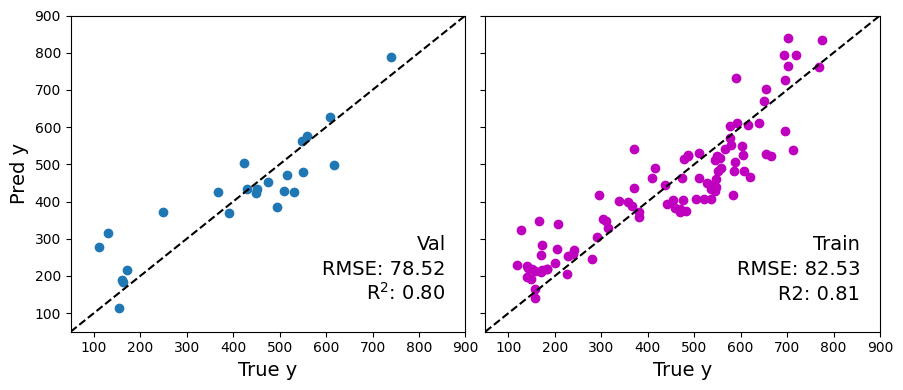

Root mean squared error: 78.52
Coefficient of determination: 0.80


In [ ]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [ ]:
errors = pd.DataFrame(errors)
errors

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,80.864286,0.795547,85.799257,0.837913
1,2,83.732501,0.800274,73.432834,0.834738
2,3,77.280666,0.823255,101.215500,0.733636
3,4,80.246476,0.826733,92.368961,0.638148
4,5,82.527396,0.807746,78.516907,0.801528


### Question
4. Why error on training set is consistently lower than that on validation set?
5. Further, the errors on various validation sets are also different. Which is the correct value that best *estimate* the performance of the ML model? 

In [ ]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

### 5. Polynomial Regression

#### Building polynomial features

In [ ]:
new_data = data.copy()

In [ ]:
def make_new_feature(data, cols, powers, new_col_name):
    """
    Function to create new features:
    Example: 
    Input: cols = x1,x2; powers = 2,3; new_col_name = n1
    Output: n1= x1**2 * x2**3
    """
    data[new_col_name] = 1
    for power, col in zip(powers, cols):
        data[new_col_name] = data[new_col_name] * (data[Xcols[col]] ** power)
        
    return data

In [ ]:
cols = [0,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.1')

In [ ]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529
...,...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778


In [ ]:
cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.2')

cols = [2,4]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'n.3')

cols = [3,4,5]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.4')

cols = [4,5]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.5')

In [ ]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1,n.2,n.3,n.4,n.5
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.015625,0.000000,0.062500
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337,0.023669,0.003641,0.001821,0.023669
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691,0.024691,0.000000,0.010974,0.049383
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837,0.015306,0.000364,0.000729,0.010204
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529,0.033058,0.006011,0.006011,0.033058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556,0.055556,0.000000,0.004630,0.027778
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000,0.000000,0.057246,0.000000,0.064879
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667,0.020833,0.004630,0.002315,0.027778
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778,0.000000,0.009259,0.000000,0.027778


In [ ]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("n.")]
X = new_data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1,n.2,n.3,n.4,n.5
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.015625,0.000000,0.062500
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337,0.023669,0.003641,0.001821,0.023669
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691,0.024691,0.000000,0.010974,0.049383
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837,0.015306,0.000364,0.000729,0.010204
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529,0.033058,0.006011,0.006011,0.033058
...,...,...,...,...,...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556,0.055556,0.000000,0.004630,0.027778
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000,0.000000,0.057246,0.000000,0.064879
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667,0.020833,0.004630,0.002315,0.027778
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778,0.000000,0.009259,0.000000,0.027778


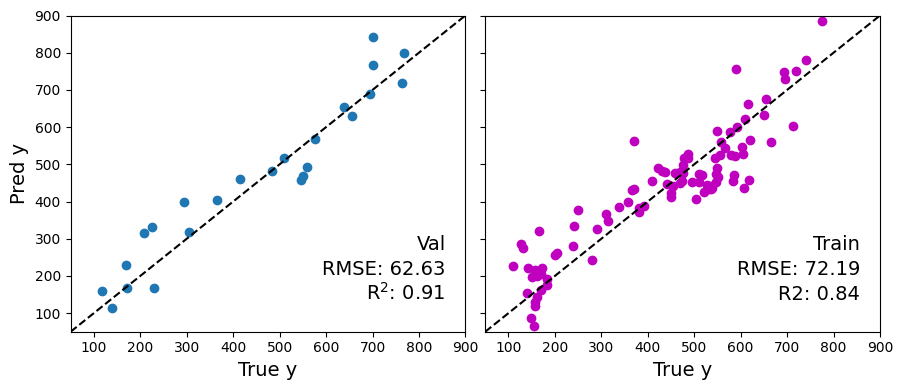

Root mean squared error: 62.63
Coefficient of determination: 0.91


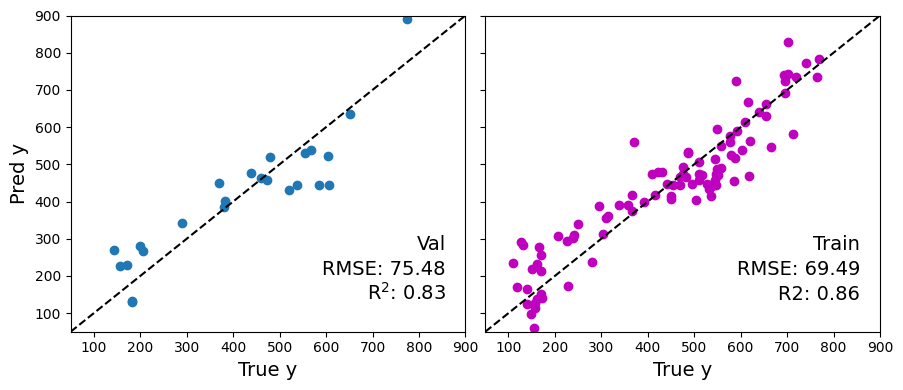

Root mean squared error: 75.48
Coefficient of determination: 0.83


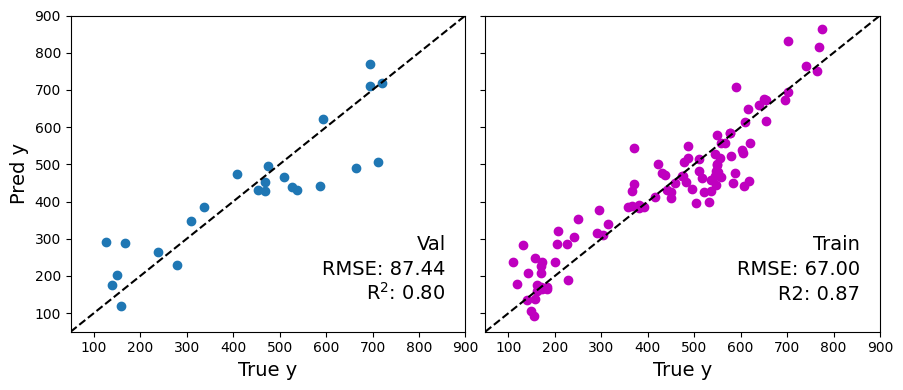

Root mean squared error: 87.44
Coefficient of determination: 0.80


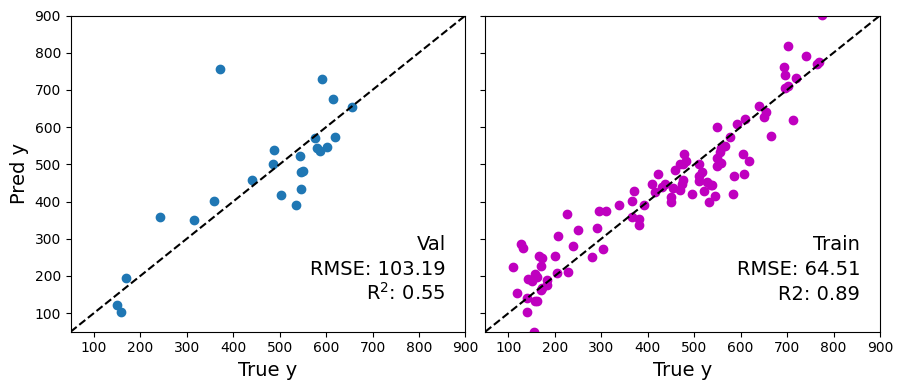

Root mean squared error: 103.19
Coefficient of determination: 0.55


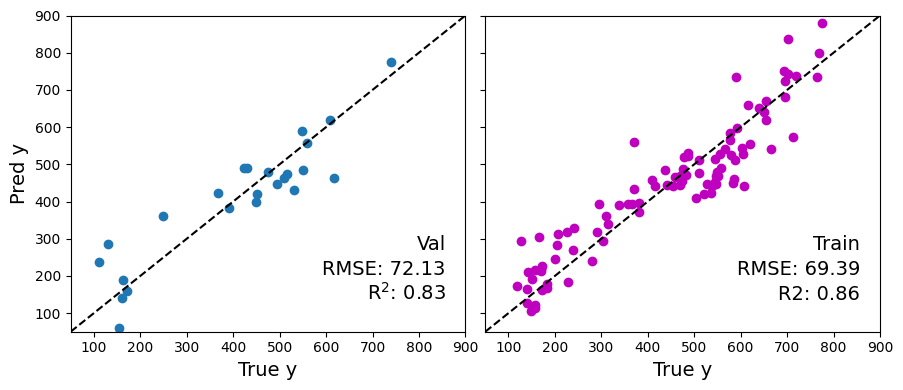

Root mean squared error: 72.13
Coefficient of determination: 0.83


In [ ]:
kf = KFold(n_splits=5)

errors_pr = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors_pr.append(error)
errors_pr = pd.DataFrame(errors_pr)    

In [ ]:
errors_pr[['rmse_val','r2_val']].mean()

rmse_val    80.175233
r2_val       0.784219
dtype: float64

In [ ]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

### Question
6. Why polynomial regression model has better accuracy than that of linear regression model?

### 6. Regularization

In [ ]:
pr_l2 = Ridge(alpha=1)

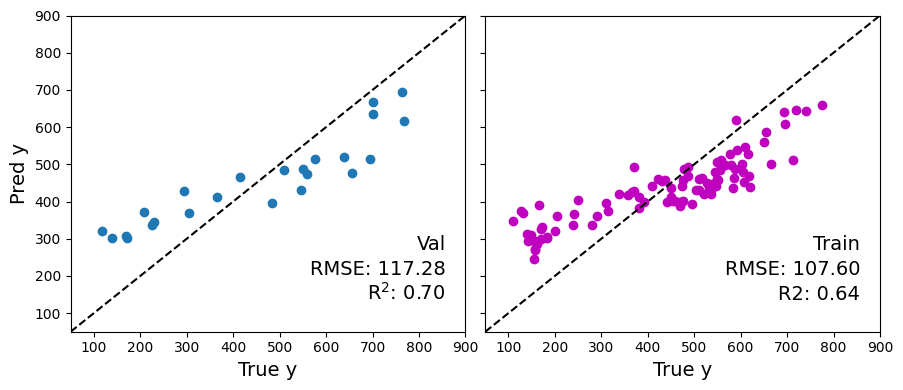

Mean squared error: 117.28
Coefficient of determination: 0.70


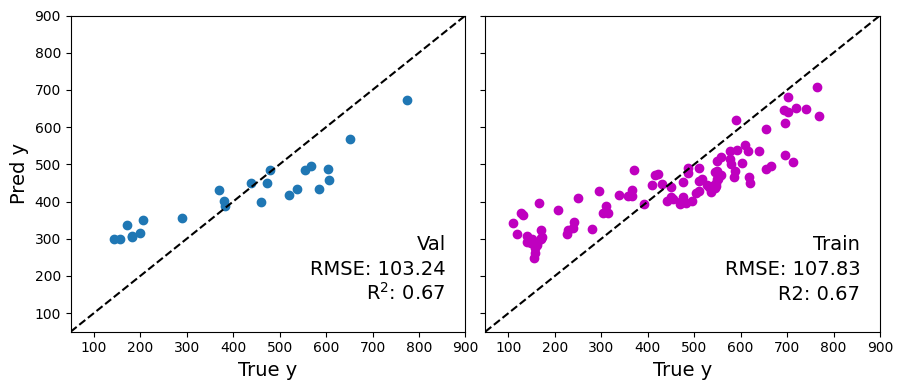

Mean squared error: 103.24
Coefficient of determination: 0.67


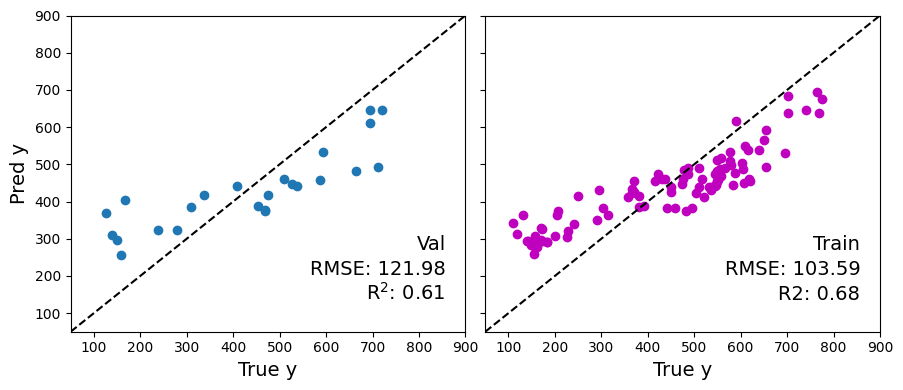

Mean squared error: 121.98
Coefficient of determination: 0.61


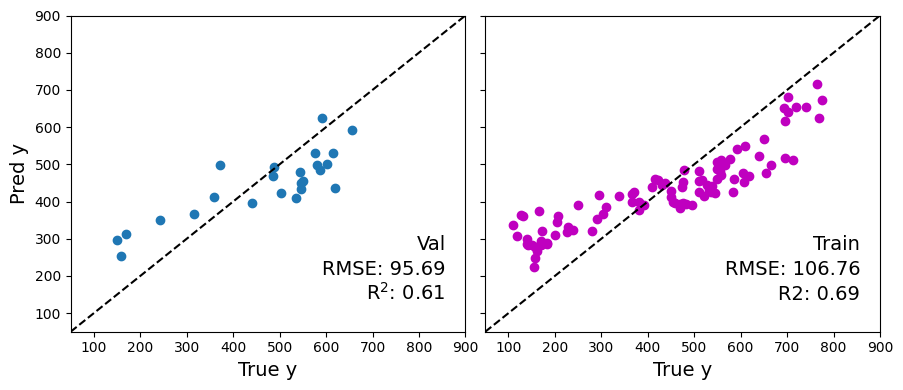

Mean squared error: 95.69
Coefficient of determination: 0.61


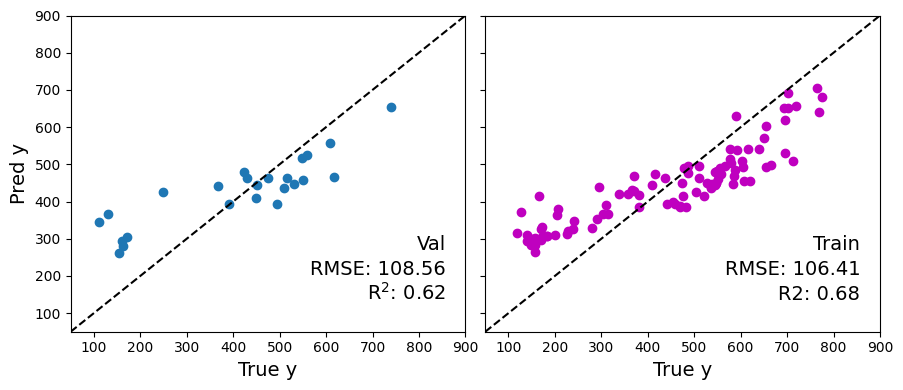

Mean squared error: 108.56
Coefficient of determination: 0.62


In [ ]:
errors_pr_l2 = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_l2.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_pr_l2.append(error)
errors_pr_l2 = pd.DataFrame(errors_pr_l2)

### Question
7. Regularization seems to decrease model accuracy. Can you spot someway of improving performance of the regularized model? 

### 6.1 Regularization with coefficient optimization

In [ ]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

In [ ]:
lr_ridge = Ridge()
clf = GridSearchCV(lr_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

In [ ]:
_ = clf.fit(X,y)

rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 80.37746946,  78.74822196,  78.5320316 ,  78.40731424,
        78.33075385,  78.3187628 ,  78.34695547,  78.55197774,
        81.34239268,  84.25826775,  85.24084833, 109.75686778,
       129.52780229])

Text(0, 0.5, 'RMSE')

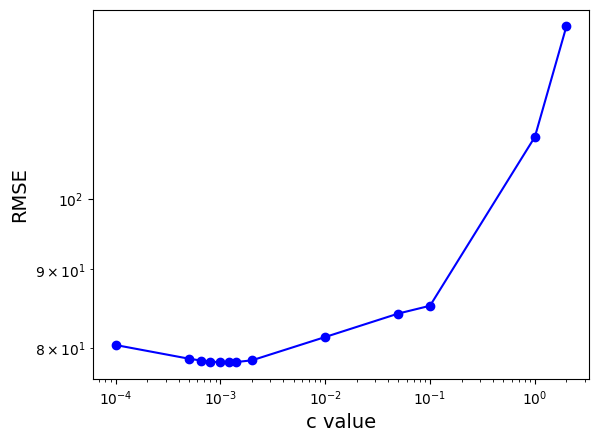

In [ ]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [ ]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0012, 78.31876280147227)

In [ ]:
c_opt = c_values[min_idx]

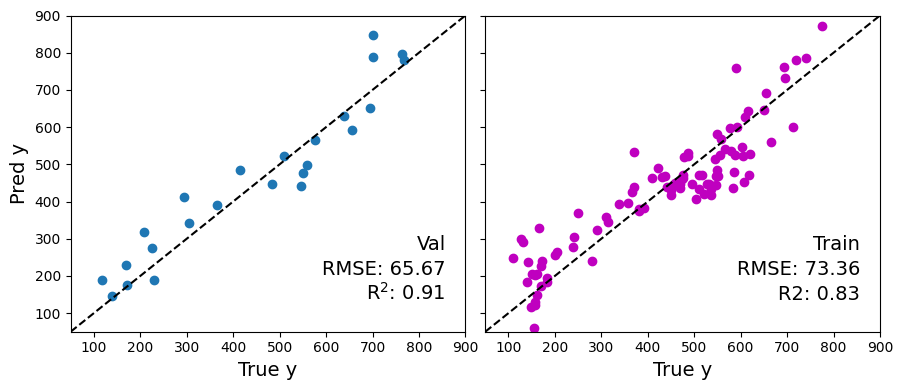

Root Mean squared error: 65.67
Coefficient of determination: 0.91


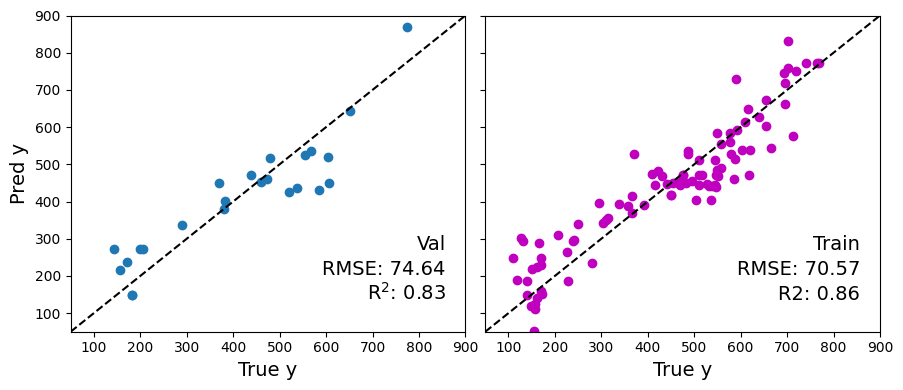

Root Mean squared error: 74.64
Coefficient of determination: 0.83


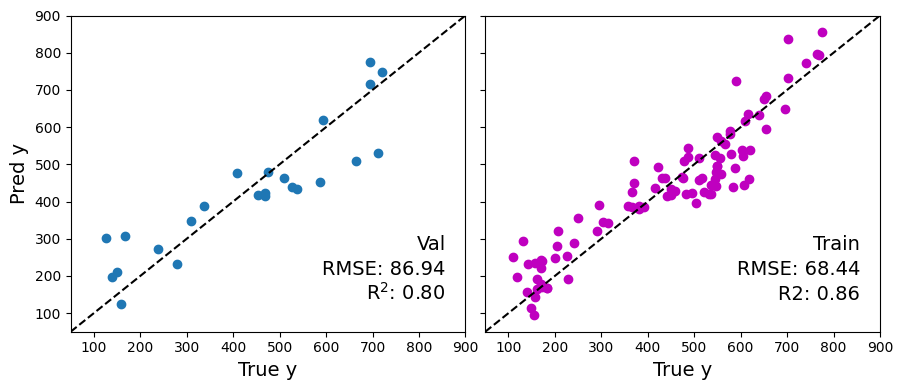

Root Mean squared error: 86.94
Coefficient of determination: 0.80


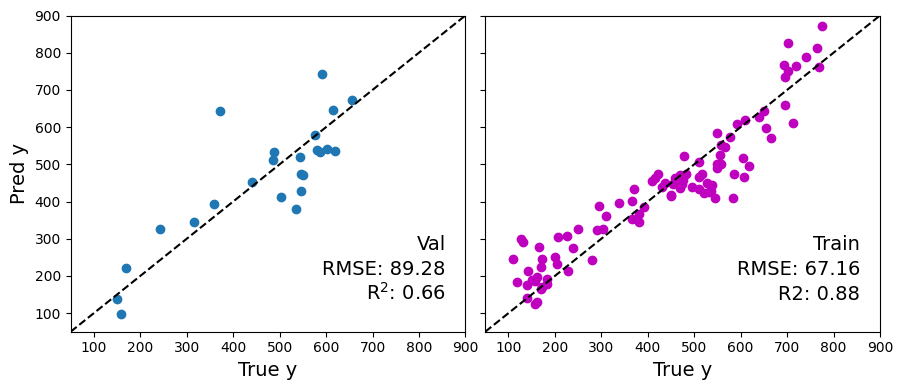

Root Mean squared error: 89.28
Coefficient of determination: 0.66


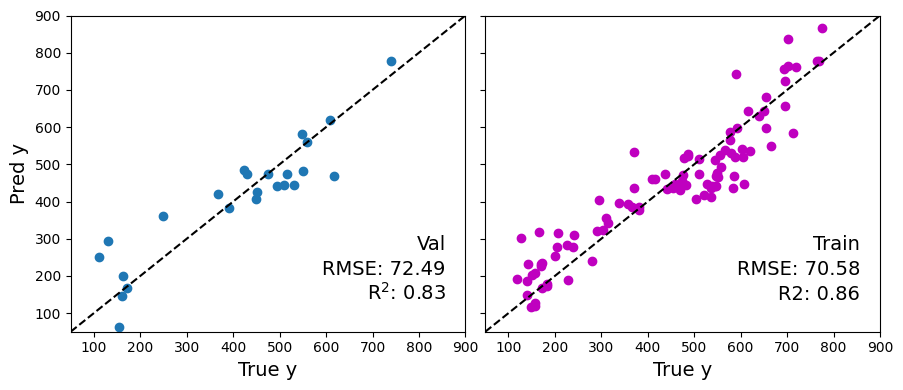

Root Mean squared error: 72.49
Coefficient of determination: 0.83


In [ ]:
pr_ridge_c_opt = Ridge(alpha=c_opt)

errors_l2_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_ridge_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_l2_c_opt.append(error)
errors_l2_c_opt = pd.DataFrame(errors_l2_c_opt)

In [ ]:
errors_l2_c_opt[['rmse_val','r2_val']].mean()

rmse_val    77.805559
r2_val       0.806103
dtype: float64

### Question
8. Try making new polynomial type features to improve polynomial regression model accuracy. Explain why addition of new features could improve model performance. 

### 7. Compare performance of all models trained

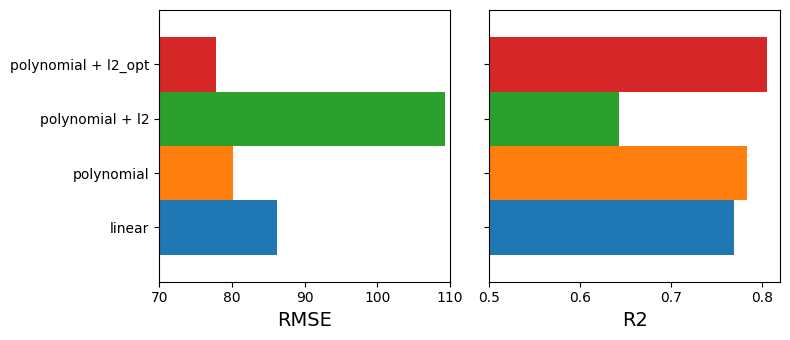

In [ ]:
width = 0.1
labels = ['linear','polynomial','polynomial + l2','polynomial + l2_opt']
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)
    
for idx,e in enumerate([errors, errors_pr, errors_pr_l2, errors_l2_c_opt]):
    mse = e.mean()['rmse_val']
    r2 = e.mean()['r2_val']
    
    ax1.barh(0 + width*(idx-1), mse, height=width, label=labels[idx], align='center')
    ax2.barh(0 + width*(idx-1), r2, height=width, label=labels[idx], align='center')    
    
ax1.set_xlabel('RMSE', fontsize=14)
ax2.set_xlabel('R2', fontsize=14)    

ax1.set_yticks([-0.1,0,0.1,0.2])
ax1.set_yticklabels(labels)

ax1.set_ylim(-0.2,0.3)
ax1.set_xlim(70,110)
ax2.set_xlim(0.5,0.82)

plt.tight_layout()
plt.show()